In [17]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import math
# plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
def calc_di(distances, k, d_bar=True):
    di = distances.apply(lambda x: x.nsmallest(k).mean()).values
    return (di, di.mean()) if d_bar else di    

In [3]:
def cloud(references, tests, k):
    """
    reference: pd.DataFrame
        Should represent a distance matrix where rows and columns are indexed by reference sample ids
    tests: pd.DataFrame
        Should represent a distance matrix where row are indexed by reference sample ids and columns are indexed
        by tests sample ids
    k: int
        The number of k nearest neighbors to look at
    """
    reference_ids = references.columns.to_list()
    test_ids = tests.columns.to_list()
    # step 1 and 2
    r_di, d_bar = calc_di(references, k)
    
    # step 3
    r_ri = r_di / d_bar
    
    # step 4
    t_di = calc_di(tests, k, d_bar=False)
    t_ri = t_di / d_bar
    
    return (t_di)

In [4]:
def get_reference_set(distances, samples, ref_lam, s_r, p_k, num_samplings=10):
    # get full "normal" set
    distances = distances.loc[ref_lam(samples)]
    distances = distances[distances.index]
    
    # calculate k
    size = int(distances.shape[0] * s_r)
    k = int(p_k * size)
    _, d_bar = calc_di(distances, k)
    
    # find s_bar closest to d_bar
    best_ref = None
    best_bar_sep = np.inf
    for _ in range(num_samplings):
        ref_distances = distances.sample(size)
        ref_distances = ref_distances[ref_distances.index]
        _, s_bar = calc_di(ref_distances, k)
        s_bar_dist = s_bar - d_bar
        if s_bar_dist < best_bar_sep:
            best_ref = ref_distances
            best_bar_sep = s_bar_dist
    return (best_ref, k)

In [5]:
def get_ref_train_test(distances, samples, ref_lam, anom_lam, s_r, p_k):
    # get reference set
#     reference_distances = distances.loc[ref_lam(samples)]
#     reference_distances = reference_distances.sample(int(reference_distances.shape[0]*.6))
#     reference_distances = reference_distances[reference_distances.index]
    reference_distances, k = get_reference_set(distances, samples, ref_lam, s_r, p_k)
    ref_ids = np.array(reference_distances.index.to_list())
    
    # get train set
    train_set_distances = distances.loc[
        (anom_lam(samples)) & ~(samples.index.isin(ref_ids)),
        ref_ids
    ]
    train_set_distances = train_set_distances.sample(int(train_set_distances.shape[0]*.8))
    train_set_ids = train_set_distances.index.to_list()
    train_set_distances = train_set_distances.T
    
    test_set_distances = distances.loc[
        (anom_lam(samples)) & ~(samples.index.isin(np.concatenate((ref_ids, train_set_ids)))),
        reference_distances.index.to_list()
    ].T
    return (reference_distances, train_set_distances, test_set_distances, k)

In [6]:
distances = pd.read_csv("artifact_110218_021021-144748/BIOM/110218/distance-matrix.tsv", sep="\t", index_col=0)
distances = distances.replace(0, np.nan)
distance_ids = distances.index.to_list()
samples = pd.read_csv("artifact_110218_021021-144748/BIOM/110218/sample.tsv", sep="\t", index_col=0)
samples = samples.loc[distance_ids]

# get ref, train, test for m3 vs f4

In [7]:
# for i in (range(1, 10)):
#     ref_dist, train_dist, test_dist, k = get_ref_train_test(
#         distances,
#         samples,
#         lambda df: (df.host == "M3"),
#         lambda df: (df.host == "M3") | (df.host == "F4"),
#         0.6,
#         0.05
#     )
#     train_ids = train_dist.columns.to_list()
#     test_ids = test_dist.columns.to_list()

# AUC for m3 vs f4

143 1 1
143 1 2
143 1 3
143 1 4
143 1 5
143 1 6
143 1 7
143 1 8
143 1 9
286 2 1
286 2 2
286 2 3
286 2 4
286 2 5
286 2 6
286 2 7
286 2 8
286 2 9
429 3 1
429 3 2
429 3 3
429 3 4
429 3 5
429 3 6
429 3 7
429 3 8
429 3 9
573 4 1
573 4 2
573 4 3
573 4 4
573 4 5
573 4 6
573 4 7
573 4 8
573 4 9
716 5 1
716 5 2
716 5 3
716 5 4
716 5 5
716 5 6
716 5 7
716 5 8
716 5 9
859 6 1
859 6 2
859 6 3
859 6 4
859 6 5
859 6 6
859 6 7
859 6 8
859 6 9


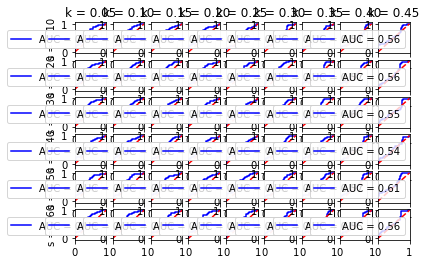

In [42]:
i_s, j_s = (6,9)
fig, axs = plt.subplots(i_s,j_s)
sizes = [0] * i_s
ks = [0] * j_s
for i in range(1, i_s+1):
    for j in range(1, j_s+1):
        ref_dist, train_dist, test_dist, k = get_ref_train_test(
            distances,
            samples,
            lambda df: (df.host == "M3"),
            lambda df: (df.host == "M3") | (df.host == "F4"),
            i * 0.1,
            j * 0.05
        )
        train_ids = train_dist.columns.to_list()
        test_ids = test_dist.columns.to_list()

        x = np.array(cloud(ref_dist, train_dist, k))
        x = x.reshape(-1, 1)
        y = samples.loc[train_ids, "host"] == "M3"
        y = np.array(y.to_list())
        y = y.reshape(y.size,)

        mdl = LogisticRegression()
        mdl = mdl.fit(x,y)

        x = np.array(cloud(ref_dist, test_dist, k))
        x = x.reshape(-1, 1)
        y = samples.loc[test_ids, "host"] == "M3"
        y = np.array(y.to_list())
        y = y.reshape(y.size,)
        probs = mdl.predict_proba(x)
        preds = probs[:,1]
        fpr, tpr, thres = metrics.roc_curve(y, preds)
        roc_auc = metrics.auc(fpr, tpr)

        axs[i-1, j-1].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        axs[i-1, j-1].legend(loc = 'lower right')
        axs[i-1, j-1].plot([0, 1], [0, 1],'r--')
        axs[i-1, j-1].set_xlim([0, 1])
        axs[i-1, j-1].set_xlim([0, 1])
#         axs[i-1, j-1].set_ylabel("k = " + str(size))
        
        sizes[i-1] = i * 0.1
        ks [j-1] = j * 0.05
        print(ref_dist.shape[0], i, j)

for i in range(i_s):
    axs[i, 0].set_ylabel("s = %0.2f" % sizes[i])
        
for j in range(j_s):
    axs[0, j].set_title("k = %0.2f" % ks[j])

# # Hide x labels and tick labels for top plots and y ticks for right plots.
#

In [43]:
 for ax in axs.flat:
    ax.label_outer()

fig.set_size_inches(20,20)
fig.savefig('mean.png', bbox_inches='tight')

# ref, train, test m3 gut vs f4 gut

In [ ]:
ref_dist, train_dist, test_dist = get_ref_train_test(
    distances,
    samples,
    lambda df: (df.host == "M3") & (df.env_package == "human-gut"),
    lambda df: (df["env_package"] == "human-gut")
)
train_ids = train_dist.columns.to_list()
test_ids = test_dist.columns.to_list()

# AUC for m3 gut vs f4 gut

In [ ]:
x = np.array(cloud(ref_dist, train_dist, 8))
x = x.reshape(-1, 1)
y = samples.loc[train_ids, "host"] == "M3"
y = np.array(y.to_list())
y = y.reshape(y.size,)

mdl = LogisticRegression()
mdl = mdl.fit(x,y)

x = np.array(cloud(ref_dist, test_dist, 8))
x = x.reshape(-1, 1)
y = samples.loc[test_ids, "host"] == "M3"
y = np.array(y.to_list())
y = y.reshape(y.size,)
probs = mdl.predict_proba(x)
preds = probs[:,1]
fpr, tpr, thres = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC m3 gut vs f4 gut')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# ref, train, test m3 skin vs f4 skin

In [ ]:
ref_dist, train_dist, test_dist = get_ref_train_test(
    distances,
    samples,
    lambda df: (df.host == "M3") & (df.env_package == "human-skin"),
    lambda df: (df["env_package"] == "human-skin")
)
train_ids = train_dist.columns.to_list()
test_ids = test_dist.columns.to_list()

In [ ]:
x = np.array(cloud(ref_dist, train_dist, 2))
x = x.reshape(-1, 1)
y = samples.loc[train_ids, "host"] == "M3"
y = np.array(y.to_list())
y = y.reshape(y.size,)

mdl = LogisticRegression()
mdl = mdl.fit(x,y)

x = np.array(cloud(ref_dist, test_dist, 2))
x = x.reshape(-1, 1)
y = samples.loc[test_ids, "host"] == "M3"
y = np.array(y.to_list())
y = y.reshape(y.size,)
probs = mdl.predict_proba(x)
preds = probs[:,1]
fpr, tpr, thres = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC m3 skin vs f4 skin')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# ref, train, test m3 oral vs f4 oral

In [ ]:
ref_dist, train_dist, test_dist = get_ref_train_test(
    distances,
    samples,
    lambda df: (df.host == "M3") & (df.env_package == "human-oral"),
    lambda df: (df["env_package"] == "human-oral")
)
train_ids = train_dist.columns.to_list()
test_ids = test_dist.columns.to_list()

In [ ]:
x = np.array(cloud(ref_dist, train_dist, 61))
x = x.reshape(-1, 1)
y = samples.loc[train_ids, "host"] == "M3"
y = np.array(y.to_list())
y = y.reshape(y.size,)

mdl = LogisticRegression()
mdl = mdl.fit(x,y)

x = np.array(cloud(ref_dist, test_dist, 61))
x = x.reshape(-1, 1)
y = samples.loc[test_ids, "host"] == "M3"
y = np.array(y.to_list())
y = y.reshape(y.size,)
probs = mdl.predict_proba(x)
preds = probs[:,1]
fpr, tpr, thres = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC m3 oral vs f4 oral')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
best_auc, best_k = (0,0)
for k in range(1, len(train_ids)):
    x = np.array(cloud(ref_dist, train_dist, k))
    x = x.reshape(-1, 1)
    y = samples.loc[train_ids, "host"] == "M3"
    y = np.array(y.to_list())
    y = y.reshape(y.size,)
    
    mdl = LogisticRegression()
    mdl = mdl.fit(x,y)
    
    x = np.array(cloud(ref_dist, test_dist, k))
    x = x.reshape(-1, 1)
    y = samples.loc[test_ids, "host"] == "M3"
    y = np.array(y.to_list())
    y = y.reshape(y.size,)
    probs = mdl.predict_proba(x)
    preds = probs[:,1]
    fpr, tpr, thres = metrics.roc_curve(y, preds)
    roc_auc = metrics.auc(fpr, tpr)
    if roc_auc > best_auc:
        best_auc, best_k = roc_auc, k
    print(roc_auc, "better!" if best_auc == roc_auc else "", k, len(train_ids))

In [ ]:
5 < np.inf

In [ ]:
for i in (range(1, 10)):
    print(i)